### Data Transformation

In [1]:
from utils import split_sequence, get_apple_close_price, plot_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
apple_close_price = get_apple_close_price()

Let's first train/test split our timeseries:

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train, test = train_test_split(apple_close_price, 
                               test_size=0.05, 
                               shuffle=False)

/usr/local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


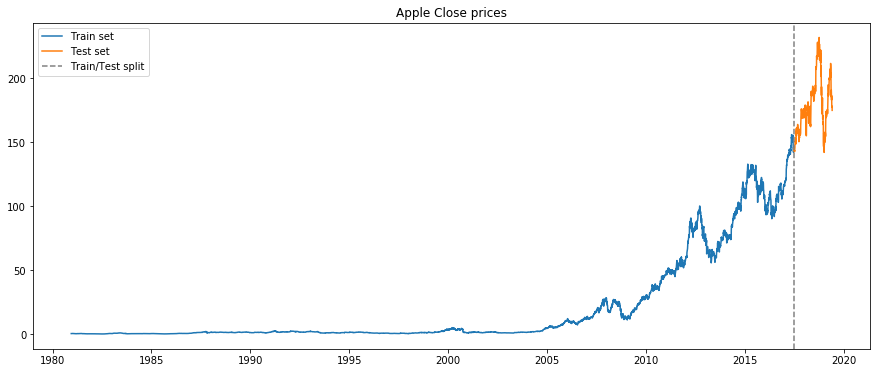

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(train)
plt.plot(test)
plt.axvline(x=train.index[-1], color='grey', linestyle='--', )
ax.set_title('Apple Close prices')
ax.legend(['Train set', 'Test set', 'Train/Test split'])

Let's perform some transformations. Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. What kind of distribution do we have here?

In [23]:
train.describe()

count    9214.000000
mean       19.960634
std        35.483055
min         0.196429
25%         1.024554
50%         1.615000
75%        18.711785
max       156.100006
Name: Close, dtype: float64

In [7]:
def dist_plot(series, figsize=(15, 6)):
    plt.subplots(figsize=figsize)
    sns.distplot(series)

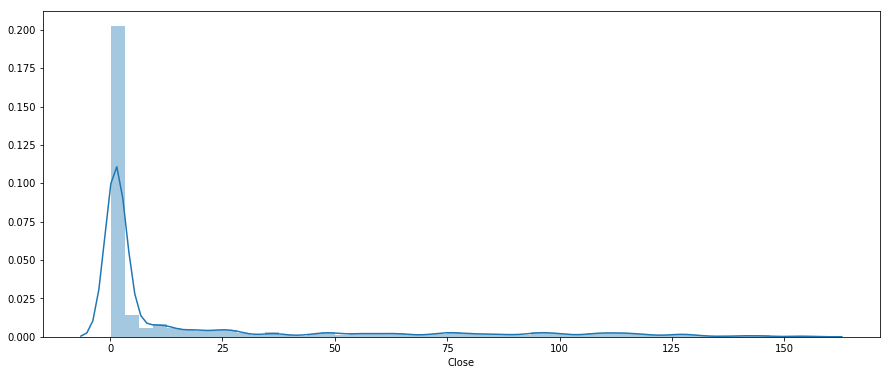

In [24]:
dist_plot(train)

As we can see it's right skewed. By applying a power transform we make it more-normal (Gaussian), removing a change in variance over time. We saw while exploring the trend that a polynomial fit, degree 4, seems to fit quite well the timeseries:

In [10]:
from numpy import polyfit

In [42]:
X = np.array([i for i in range(0, len(train))]).reshape(-1,)
y = np.array(train).reshape(-1,)

degree = 4

coef = polyfit(X, y, degree) 
print('Coefficients: %s' % coef)

Coefficients: [ 5.15814378e-14 -2.39576494e-10 -9.68406288e-07  4.75717963e-03
 -2.04655164e+00]


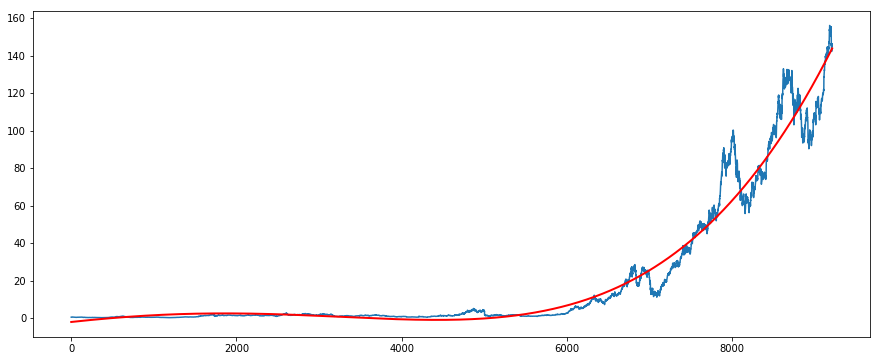

In [43]:
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
plt.subplots(figsize=(15, 6))
plt.plot(y)
plt.plot(curve, color='red', linewidth=2)

Therefore let's apply this power transformation

In [27]:
power_1_4_series = np.power(train, 1/4)

In [28]:
power_1_4_series.describe()

count    9214.000000
mean        1.551938
std         0.810755
min         0.665735
25%         1.006083
50%         1.127309
75%         2.079834
max         3.534685
Name: Close, dtype: float64

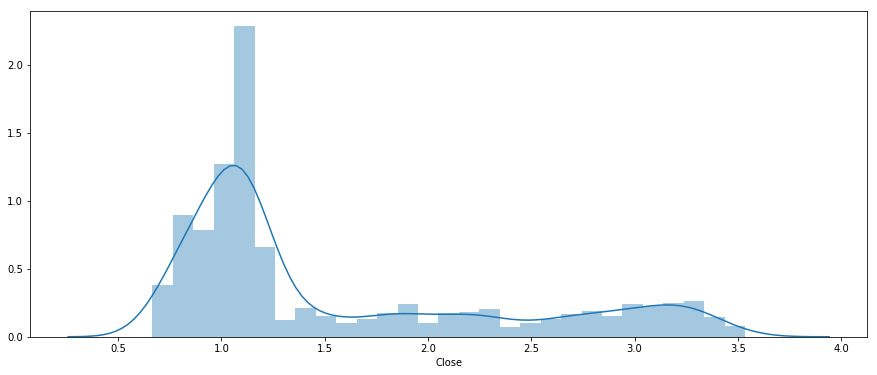

In [29]:
dist_plot(power_1_4_series)

Looks more gaussian-like, but not enough. Let's try log-transform

In [30]:
log_series = np.log(train)

In [31]:
log_series.describe()

count    9214.000000
mean        1.290854
std         1.859246
min        -1.627454
25%         0.024257
50%         0.479335
75%         2.929153
max         5.050497
Name: Close, dtype: float64

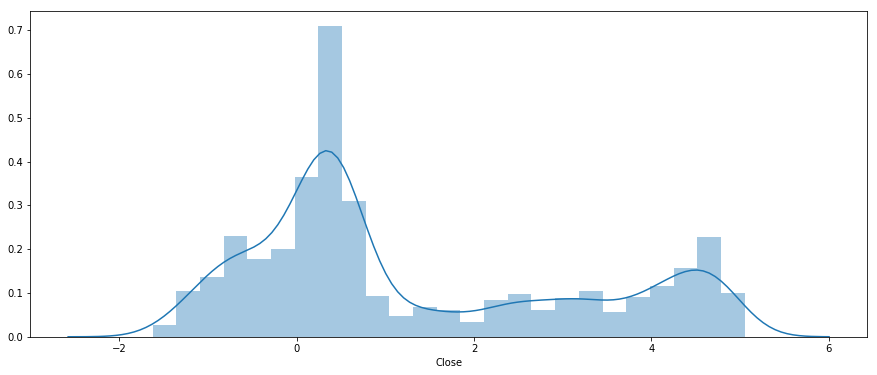

In [32]:
dist_plot(log_series)

A bit better. Let's make use of [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html) to find the best transformation

In [21]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [33]:
boxcox_series, lmbda = boxcox(train.values)
print('Best lmbda for Box-Cox test:', lmbda)

Best lmbda for Box-Cox test: -0.24572155857082034


In [34]:
pd.Series(boxcox_series).describe()

count    9214.000000
mean        0.818581
std         1.253619
min        -2.000949
25%         0.024185
50%         0.452183
75%         2.088254
max         2.893151
dtype: float64

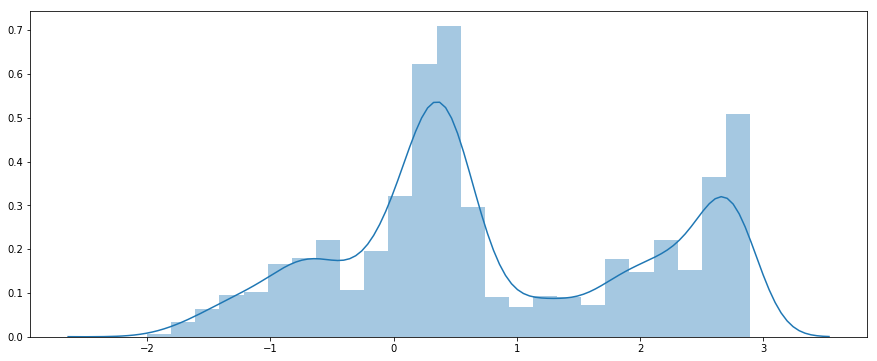

In [35]:
dist_plot(boxcox_series)

Looks a bit better. Let's now transformed also the test set using the `lmda` value provided by BoxCox

In [49]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

Time to scale the values

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
scaler = MinMaxScaler()

In [50]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))

In [52]:
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [56]:
pd.Series(scaled_train.reshape(-1,)).describe()

count    9214.000000
mean        0.576108
std         0.256149
min         0.000000
25%         0.413791
50%         0.501243
75%         0.835537
max         1.000000
dtype: float64

In [57]:
pd.Series(scaled_test.reshape(-1,)).describe()

count    485.000000
mean       1.007659
std        0.006599
min        0.994423
25%        1.002774
50%        1.006657
75%        1.011643
max        1.022318
dtype: float64

The next step is to split the sequence into features, `X`, and labels, `y`, to re-frame the timeseries forecasting as supervised learning problem

In [59]:
look_back = 3 # days back
X_train, y_train = split_sequence(scaled_train, look_back)
X_test, y_test = split_sequence(scaled_test, look_back)

In [60]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (9211, 3, 1)
Shape of y_train: (9211, 1)
